# CS543 Final Project CP1

04-14-2019

Yu Chen, Yu Chen, Yite Wang, Yuan Zhang

yuc5@illinois.edu; yuc6@illinois.edu; yitew2@illinois.edu; yuanz4@illinois.edu; 

## Include libraries

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rot
import cv2
import re
import math
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## Functions

In [3]:
def solve(index):
    IMG_DIR = 'image_0/'
    num1 = str(index)
    num2 = str(index+1)
    num1_0 = 6-len(num1)
    num2_0 = 6-len(num2)
    IMG_NAME_1 = '0'*num1_0 + num1 + '.png'
    IMG_NAME_2 = '0'*num2_0 + num2 + '.png'

    img_1 = cv2.imread(IMG_DIR + IMG_NAME_1)
    img_2 = cv2.imread(IMG_DIR + IMG_NAME_2)

    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img_1,None)
    kp2, des2 = sift.detectAndCompute(img_2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
    pts1_E = np.asarray(pts1)
    pts2_E = np.asarray(pts2)
    E, mask = cv2.findEssentialMat(pts1_E, pts2_E, focal=fl, pp=pp)
    _, R, t, _ = cv2.recoverPose(E, pts1_E, pts2_E, focal=fl, pp=pp, mask=mask)

    return E, R, t.T

## Read camera parameters

In [4]:
# Find Intrinsic Parameters
CamP = np.loadtxt('KITTI  sample dataset/dataset/sequences/00/calib.txt','str')[:,1:].astype(np.float)
P0 = CamP[0,:].reshape((3,4))
fl = P0[0, 0]
pp = (P0[0, 2], P0[1, 2])

## Read from Ground Truth

In [5]:
ReadGT = np.loadtxt('KITTI  sample dataset/dataset/poses/00.txt')
Rs = np.reshape(ReadGT,(3*len(ReadGT),4))[:,:-1]
translation = np.reshape(np.reshape(ReadGT,(3*len(ReadGT),4))[:,-1:],(len(ReadGT),3))
rotation = np.zeros([len(ReadGT),3,3])
rotation[0:len(ReadGT),0,:] = Rs[::3,:]
rotation[0:len(ReadGT),1,:] = Rs[1::3,:]
rotation[0:len(ReadGT),2,:] = Rs[2::3,:]

## Main

In [6]:
index = 4500
E = np.zeros((index, 3, 3))
r = np.zeros((index, 3, 3))
t = np.zeros((index, 3))
for i in range(index):
    E[i], r[i], t[i] = solve(i)

    if i % (index/100) == 0:
        logging.info(' '+str(100*i/index)+'%  Processed')
    elif (i == index-1):
        print('--> 100% Done')

# np.save('0-249/E_0-249', E)
# np.save('0-249/r_0-249', r)
# np.save('0-249/t_0-249', t)

INFO:root: 0.0%  Processed
INFO:root: 1.0%  Processed
INFO:root: 2.0%  Processed
INFO:root: 3.0%  Processed
INFO:root: 4.0%  Processed
INFO:root: 5.0%  Processed
INFO:root: 6.0%  Processed
INFO:root: 7.0%  Processed
INFO:root: 8.0%  Processed
INFO:root: 9.0%  Processed
INFO:root: 10.0%  Processed
INFO:root: 11.0%  Processed
INFO:root: 12.0%  Processed
INFO:root: 13.0%  Processed
INFO:root: 14.0%  Processed
INFO:root: 15.0%  Processed
INFO:root: 16.0%  Processed
INFO:root: 17.0%  Processed
INFO:root: 18.0%  Processed
INFO:root: 19.0%  Processed
INFO:root: 20.0%  Processed
INFO:root: 21.0%  Processed
INFO:root: 22.0%  Processed
INFO:root: 23.0%  Processed
INFO:root: 24.0%  Processed
INFO:root: 25.0%  Processed
INFO:root: 26.0%  Processed
INFO:root: 27.0%  Processed
INFO:root: 28.0%  Processed
INFO:root: 29.0%  Processed
INFO:root: 30.0%  Processed
INFO:root: 31.0%  Processed
INFO:root: 32.0%  Processed
INFO:root: 33.0%  Processed
INFO:root: 34.0%  Processed
INFO:root: 35.0%  Processed
IN

--> 100% Done


## Load previous results

In [7]:
# E = np.load('0-249/E_0-249.npy')
# r = np.load('0-249/r_0-249.npy')
# t = np.load('0-249/t_0-249.npy')

## Generate trajectory from results

In [7]:
T = np.zeros(3)
R = np.eye(3)
T_list = np.zeros((index, 3))
R_list = np.zeros((index, 3, 3))
for i in range(index):
    T += R @ t[i]
    R = R @ r[i]
    T_list[i] = T
    R_list[i] = R

## Trajectory validation

<IPython.core.display.Javascript object>


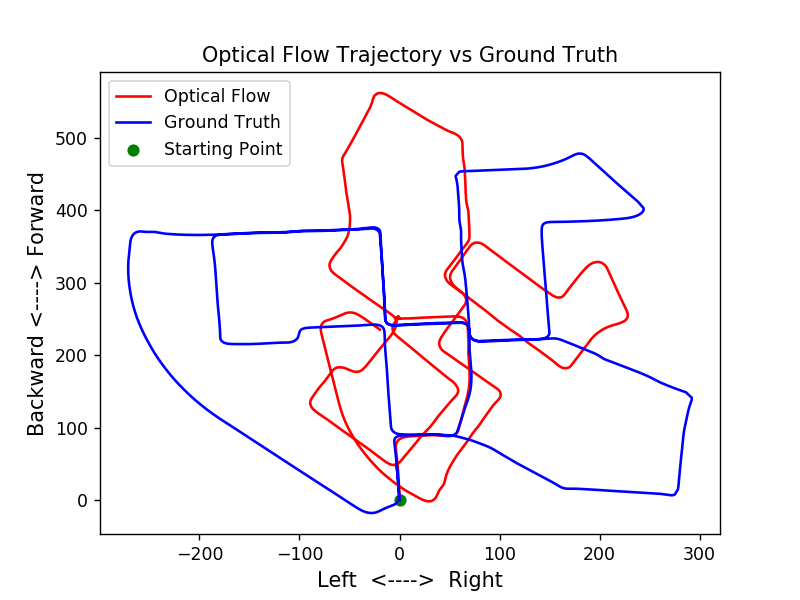

In [9]:
#scaling factor to remedy focal length unit conversion
Scaling1 = 0.61 
Scaling2 = 0.75 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(T_list[0,0], -T_list[0,2], c='g')
ax.plot(Scaling1*T_list[:,0], -Scaling2*T_list[:,2],c='r')
ax.plot(translation[:index,0], translation[:index,2],c='b')
plt.legend(['Optical Flow','Ground Truth','Starting Point'])
plt.title('Optical Flow Trajectory vs Ground Truth')
plt.xlabel('Left  <---->  Right', fontsize='12')
plt.ylabel('Backward <----> Forward', fontsize='12')
plt.show()